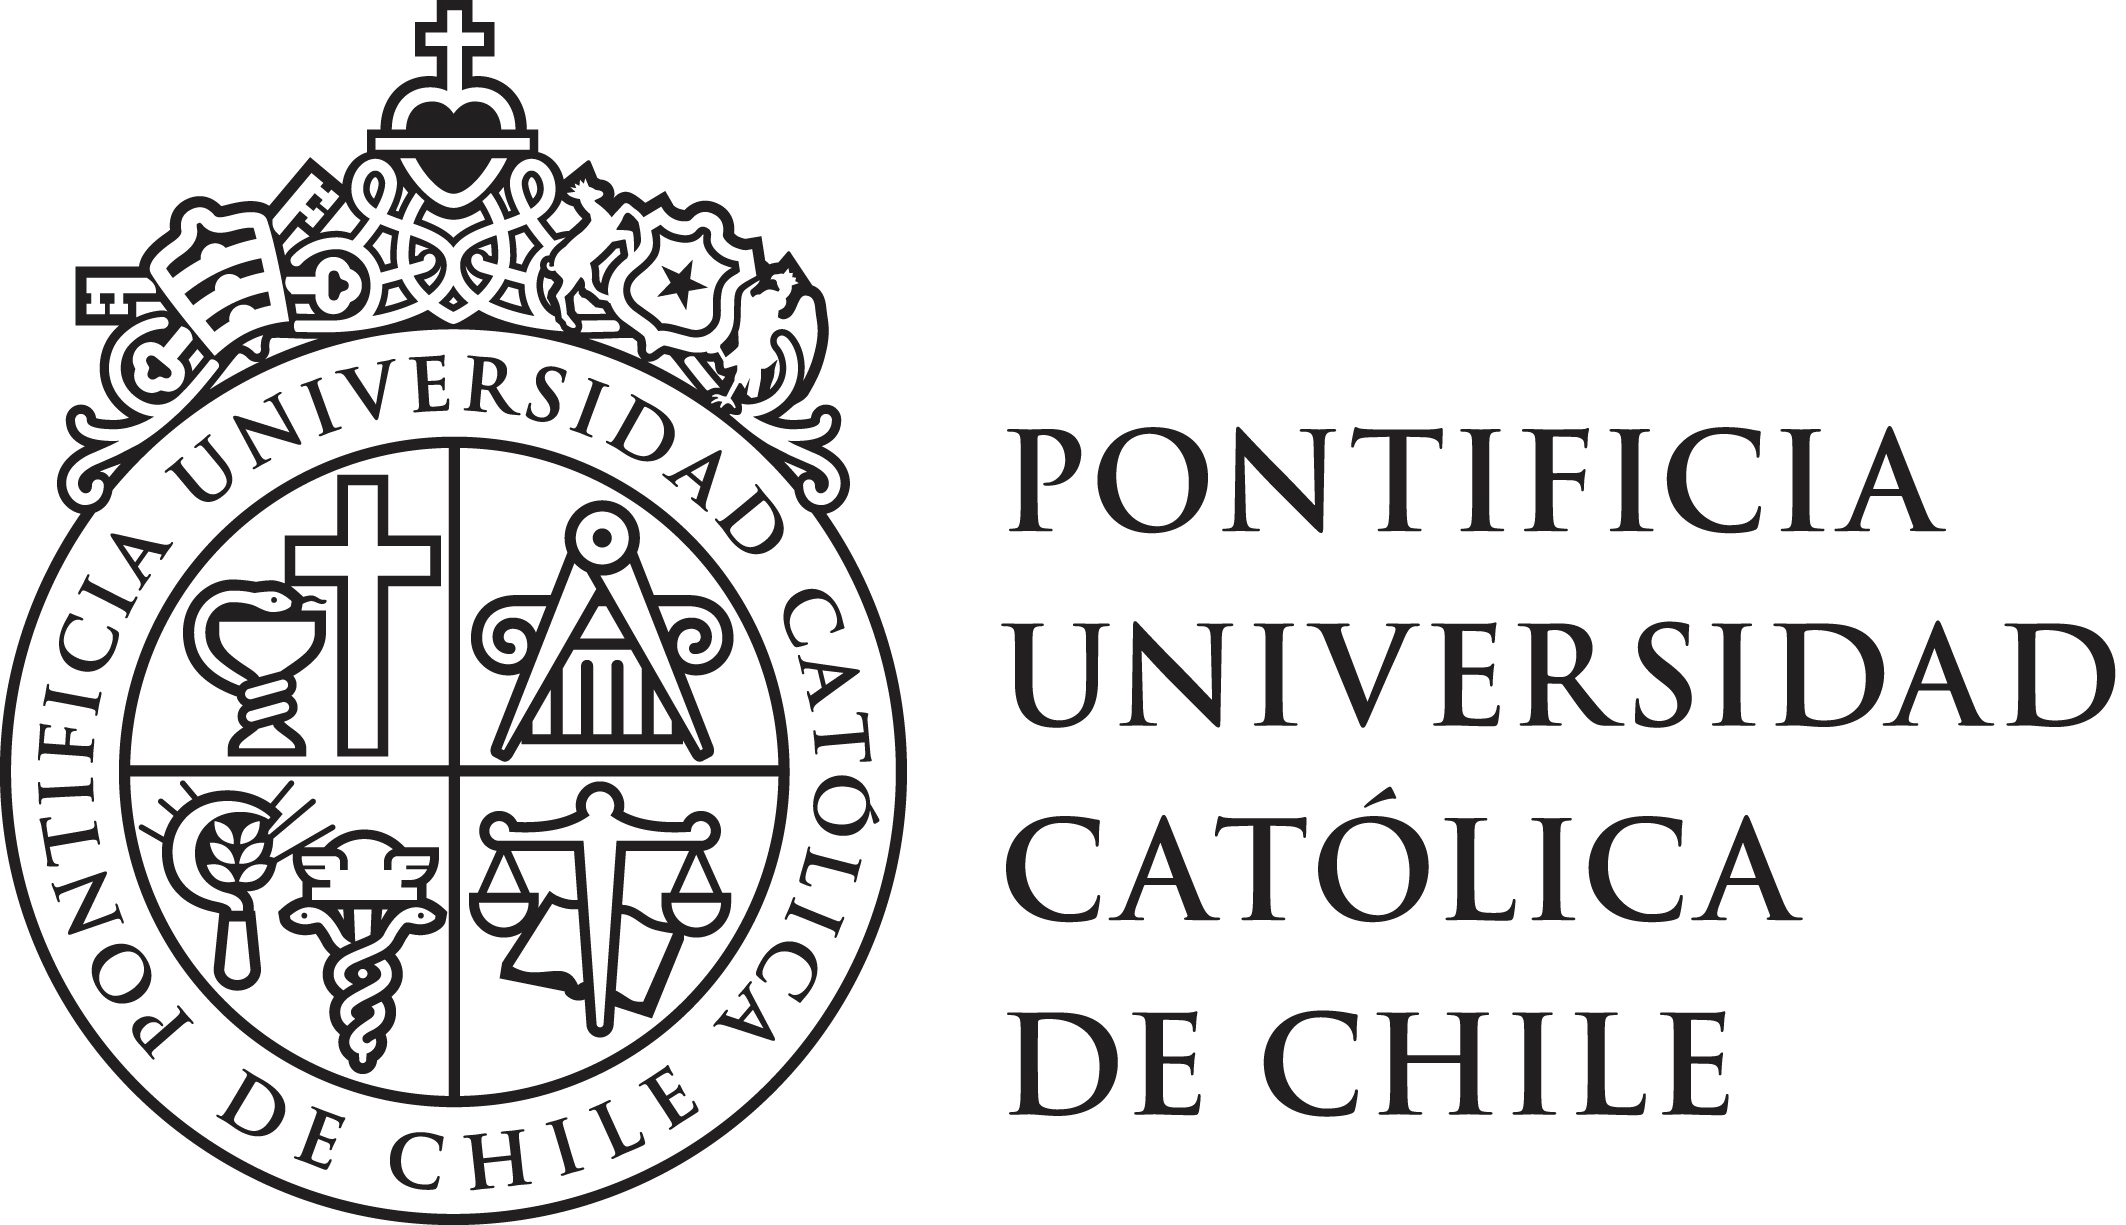

In [1]:
from IPython.display import Image

Image(filename='UC-NEGRO-01.jpg', width=200)

# PROCESAMIENTO DE LENGUAJE NATURAL

- Versiones de librerías, python 3.8.10

- spacy 3.5.1
- keras 2.9.0
- tensorflow 2.9.1
- pydantic 1.10.8


## Vamos a cargar un modelo de spacy para hacer el pipeline de texto

In [8]:
!python3 -m spacy download en_core_web_md

2024-04-23 11:13:41.293323: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-23 11:13:41.763978: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-04-23 11:13:41.764035: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-04-23 11:13:41.764042: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
2024-04-23 11:13:43.004864: W tensorf

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


## Ahora leemos una historias (cortas) y las tokenizamos

In [10]:
import pandas as pd
import spacy

train_stories = pd.read_csv('example_train_stories.csv', encoding='utf-8')

nlp = spacy.load('en_core_web_md')
nlp.add_pipe('sentencizer')

def text_to_tokens(text_seqs):
    token_seqs = [[word.lower_ for word in nlp(text_seq)] for text_seq in text_seqs]
    return token_seqs

train_stories['Tokenized_Story'] = text_to_tokens(train_stories['Story'])
    
train_stories[['Story','Tokenized_Story']][:10]

Story  \
0  Dan's parents were overweight. Dan was overwei...   
1  Carrie had just learned how to ride a bike. Sh...   
2  Morgan enjoyed long walks on the beach. She an...   
3  Jane was working at a diner. Suddenly a custom...   
4  I was talking to my crush today. She continued...   
5  Frank had been drinking beer. He got a call fr...   
6  Dave was in the Bahamas on vacation. He decide...   
7  Sunny enjoyed going to the beach. As she stepp...   
8  Sally was happy when her widowed mom found a n...   
9  Dan hit his golf ball and watched it go. The b...   

                                     Tokenized_Story  
0  [dan, 's, parents, were, overweight, ., dan, w...  
1  [carrie, had, just, learned, how, to, ride, a,...  
2  [morgan, enjoyed, long, walks, on, the, beach,...  
3  [jane, was, working, at, a, diner, ., suddenly...  
4  [i, was, talking, to, my, crush, today, ., she...  
5  [frank, had, been, drinking, beer, ., he, got,...  
6  [dave, was, in, the, bahamas, on, vacation, .,...  
7  [sunny, enjoyed, going, to, the, beach, ., as,...  
8  [sally, was, happy, when, her, widowed, mom, f...  
9  [dan, hit, his, golf, ball, and, watched, it, ...

## Construiremos el vocabulario de manera que cada palabra tenga un entero asociado

In [11]:
import pickle

def make_vocab(token_seqs, min_freq=1):
    token_counts = {}
    for seq in token_seqs:
        for token in seq:
            if token in token_counts:
                token_counts[token] += 1
            else:
                token_counts[token] = 1

    
    vocab = [token for token, count in token_counts.items() if count >= min_freq]
    
    vocab = {token:idx + 2 for idx,token in enumerate(vocab)}
    vocab[u'<UNK>'] = 1 
    vocab_size = len(vocab)

    print("VOCABULARY SAMPLE ({} total items):".format(len(vocab)))
    print(dict(list(vocab.items())[:20]))
    
    return vocab

vocab = make_vocab(token_seqs=train_stories['Tokenized_Story'], min_freq=1)

with open('vocab.pkl', 'wb') as f:
    pickle.dump(vocab, f)

VOCABULARY SAMPLE (1272 total items):
{'dan': 2, "'s": 3, 'parents': 4, 'were': 5, 'overweight': 6, '.': 7, 'was': 8, 'as': 9, 'well': 10, 'the': 11, 'doctors': 12, 'told': 13, 'his': 14, 'it': 15, 'unhealthy': 16, 'understood': 17, 'and': 18, 'decided': 19, 'to': 20, 'make': 21}


## vocab lookup nos devuelve una palabra dado un id

In [12]:
def get_vocab_lookup(vocab):
    vocab_lookup = {idx: vocab_item for vocab_item, idx in vocab.items()}
    vocab_lookup[0] = "" 
    print("LOOKUP SAMPLE:")
    print(dict(list(vocab_lookup.items())[:20]))
    return vocab_lookup

vocab_lookup = get_vocab_lookup(vocab)

LOOKUP SAMPLE:
{2: 'dan', 3: "'s", 4: 'parents', 5: 'were', 6: 'overweight', 7: '.', 8: 'was', 9: 'as', 10: 'well', 11: 'the', 12: 'doctors', 13: 'told', 14: 'his', 15: 'it', 16: 'unhealthy', 17: 'understood', 18: 'and', 19: 'decided', 20: 'to', 21: 'make'}


In [13]:
vocab_lookup[50]

'into'

## Entonces pasamos desde palabras a enteros

In [14]:
def tokens_to_idxs(token_seqs, vocab):
    idx_seqs = [[vocab[token] if token in vocab else vocab['<UNK>'] for token in token_seq]  
                                                                     for token_seq in token_seqs]
    return idx_seqs

train_stories['Story_Idxs'] = tokens_to_idxs(token_seqs=train_stories['Tokenized_Story'],
                                             vocab=vocab)
                                   
train_stories[['Tokenized_Story', 'Story_Idxs']][:10]

Tokenized_Story  \
0  [dan, 's, parents, were, overweight, ., dan, w...   
1  [carrie, had, just, learned, how, to, ride, a,...   
2  [morgan, enjoyed, long, walks, on, the, beach,...   
3  [jane, was, working, at, a, diner, ., suddenly...   
4  [i, was, talking, to, my, crush, today, ., she...   
5  [frank, had, been, drinking, beer, ., he, got,...   
6  [dave, was, in, the, bahamas, on, vacation, .,...   
7  [sunny, enjoyed, going, to, the, beach, ., as,...   
8  [sally, was, happy, when, her, widowed, mom, f...   
9  [dan, hit, his, golf, ball, and, watched, it, ...   

                                          Story_Idxs  
0  [2, 3, 4, 5, 6, 7, 2, 8, 6, 9, 10, 7, 11, 12, ...  
1  [29, 30, 31, 32, 33, 20, 34, 22, 35, 7, 36, 37...  
2  [57, 58, 59, 60, 27, 11, 61, 7, 36, 18, 41, 62...  
3  [76, 8, 77, 78, 22, 79, 7, 80, 22, 81, 82, 83,...  
4  [98, 8, 99, 20, 100, 101, 102, 7, 36, 103, 20,...  
5  [123, 30, 124, 125, 126, 7, 74, 25, 22, 127, 1...  
6  [146, 8, 147, 11, 148, 27, 149, 7, 74, 19, 20,...  
7  [169, 58, 170, 20, 11, 61, 7, 9, 36, 171, 121,...  
8  [182, 8, 183, 159, 41, 184, 185, 160, 22, 186,...  
9  [2, 203, 14, 204, 205, 18, 206, 15, 63, 7, 11,...

## Y usamos pad sequences para generar las secuencias de enteros

In [15]:
from keras_preprocessing.sequence import pad_sequences

def pad_idx_seqs(idx_seqs, max_seq_len):
    padded_idxs = pad_sequences(sequences=idx_seqs, maxlen=max_seq_len)
    return padded_idxs

max_seq_len = max([len(idx_seq) for idx_seq in train_stories['Story_Idxs']]) 

train_padded_idxs = pad_sequences(train_stories['Story_Idxs'], maxlen=max_seq_len + 1) 
print(train_padded_idxs) 

print("SHAPE:", train_padded_idxs.shape)

[[   0    0    0 ...   22   28    7]
 [   0    0    0 ...   41   56    7]
 [   0    0    0 ...   41   75    7]
 ...
 [   0    0    0 ...  107   41    7]
 [   0    0    0 ...   11 1266    7]
 [   0    0    0 ...  176  121    7]]
SHAPE: (100, 71)


## Un pandas dataframe nos muestra la relación palabra-palabra para la tarea next token prediction

In [17]:
pd.DataFrame(list(zip(["-"] + train_stories['Tokenized_Story'].loc[0],
                          train_stories['Tokenized_Story'].loc[0])),
                 columns=['Input Word', 'Output Word'])

Input Word Output Word
0            -         dan
1          dan          's
2           's     parents
3      parents        were
4         were  overweight
5   overweight           .
6            .         dan
7          dan         was
8          was  overweight
9   overweight          as
10          as        well
11        well           .
12           .         the
13         the     doctors
14     doctors        told
15        told         his
16         his     parents
17     parents          it
18          it         was
19         was   unhealthy
20   unhealthy           .
21           .         his
22         his     parents
23     parents  understood
24  understood         and
25         and     decided
26     decided          to
27          to        make
28        make           a
29           a      change
30      change           .
31           .        they
32        they         got
33         got  themselves
34  themselves         and
35         and         dan
36         dan          on
37          on           a
38           a        diet
39        diet           .

## Usaremos un modelo muy simple para hacer generación autoregresiva (next token)

In [18]:
from keras.models import Model 
from keras.layers import Dense, Embedding, TimeDistributed, Input

def create_model(seq_input_len, n_input_nodes, embedding_dim, 
                 stateful=False, batch_size=None):
    
    
    input_layer = Input(batch_shape=(batch_size, seq_input_len), name='input_layer')

    embedding_layer = Embedding(input_dim=n_input_nodes, 
                                output_dim=embedding_dim, 
                                mask_zero=True, name='embedding_layer')(input_layer) #mask_zero ignora el padding
    
    output_layer = TimeDistributed(Dense(n_input_nodes, activation="softmax"), 
                                   name='output_layer')(embedding_layer)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss="sparse_categorical_crossentropy", optimizer='adam')
    
    return model

In [19]:
model = create_model(seq_input_len=train_padded_idxs.shape[-1] - 1, #substract 1 from matrix length because of offset 
                     n_input_nodes = len(vocab) + 1, # Add 1 to account for 0 padding
                     embedding_dim = 300)

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 70)]              0         
                                                                 
 embedding_layer (Embedding)  (None, 70, 300)          381900    
                                                                 
 output_layer (TimeDistribut  (None, 70, 1273)         383173    
 ed)                                                             
                                                                 
Total params: 765,073
Trainable params: 765,073
Non-trainable params: 0
_________________________________________________________________


## Y el entrenamiento simplemente desplaza la secuencia de entrada en una posición y la coloca a la salida

In [21]:
model.fit(x=train_padded_idxs[:,:-1], y=train_padded_idxs[:, 1:, None], epochs=50, batch_size=5, verbose=False)
model.save_weights('model_weights.h5')

## Leemos los pesos que aprendimos para inferencia

In [22]:
predictor_model = create_model(seq_input_len=1,
                               n_input_nodes=len(vocab) + 1,
                               embedding_dim = 300,
                               stateful=True, 
                               batch_size = 1)

predictor_model.load_weights('model_weights.h5')

## Vamos a usar unas historias de test para explorar el modelo

In [23]:
test_stories = pd.read_csv('example_test_stories.csv', encoding='utf-8')
test_stories['Tokenized_Story'] = text_to_tokens(test_stories['Story'])
test_stories['Story_Idxs'] = tokens_to_idxs(token_seqs=test_stories['Tokenized_Story'], vocab=vocab)

## Y hacemos generación autoregresiva

In [24]:
def generate_ending(idx_seq):
    
    end_of_sent_tokens = [".", "!", "?"]
    generated_ending = []
    
    
    for word in idx_seq:
        p_next_word = predictor_model.predict(np.array(word)[None,None], verbose=False)[0,0]
        
    while not generated_ending or vocab_lookup[next_word] not in end_of_sent_tokens:
        #Randomly sample a word from the current probability distribution
        next_word = np.random.choice(a=p_next_word.shape[-1], p=p_next_word)
        # Append sampled word to generated ending
        generated_ending.append(next_word)
        # Get probabilities for next word by inputing sampled word
        p_next_word = predictor_model.predict(np.array(next_word)[None,None], verbose=False)[0,0]
    
    model.reset_states() 
    
    return generated_ending

In [25]:
import numpy as np

for _, test_story in test_stories[:20].iterrows():
    
    ending_story_idx = len(list(nlp(test_story['Story']).sents)[-1])
    print("INITIAL STORY:", " ".join(test_story['Tokenized_Story'][:-ending_story_idx]))
    print("GIVEN ENDING:", " ".join(test_story['Tokenized_Story'][-ending_story_idx:]))
    
    generated_ending = generate_ending(test_story['Story_Idxs'][:-ending_story_idx])
    generated_ending = " ".join([vocab_lookup[word] if word in vocab_lookup else ""
                                 for word in generated_ending]) 
    print("GENERATED ENDING:", generated_ending, "\n")

INITIAL STORY: lars went out skateboarding today . he skateboarded to the skate park . his friends taught him how to do a new trick . it is a difficult trick but he 's going to keep practicing .
GIVEN ENDING: tomorrow he 'll teach his friends something new too .
GENERATED ENDING: he needed and swam out of my egg hunt started crying . 

INITIAL STORY: abby is an avid scuba diver . abby 's dream has always been to scuba dive at the great barrier reef . one day abby got a letter from her father in the mail . as abby opened the letter she began crying with joy .
GIVEN ENDING: abby 's dad was sending her to the great barrier reef to dive in may .
GENERATED ENDING: frank had never a bath . 

INITIAL STORY: maggie was 100 years old . she knew her time was coming to an end soon . she gathered all of her family around her bed side . she told them her final goodbyes .
GIVEN ENDING: maggie passed away minutes later .
GENERATED ENDING: she bought her and took out . 

INITIAL STORY: july is the sea